Initialization of the $XX$ Ising chain with 0 magnetic field.

In [10]:
import numpy as np
from tqdm import tqdm

In [11]:
from lib.quantum_ising_chain import QuantumIsingChain1D

In [12]:
def build_hopping_hamiltonian(J,N):
    """
    Build the Hamiltonian for a 1D $XX$ Ising chain with zero magnetic field of N sites with periodic boundary conditions.
    
    Args:
        J (float): The coupling constant.
        N (int): Number of sites in the chain.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix.
    """
    H = np.zeros((N, N), dtype=complex)
    for i in range(N):
        H[i, (i + 1) % N] = -J/2  
        H[(i + 1) % N, i] = -J/2  
    return H

Computation of the numerical evolution with the formula
$$
    \Gamma(t) = e^{iHt} \Gamma(0) e^{-iHt}
$$

In [13]:
def gamma_0(N):   
    """
    Construct a $\Gamma(0)$ taking as the initial state the Neel state.

    Args:
        N (int): Number of sites in the chain.
    
    Returns:
        neel_state (np.ndarray): $\Gamma(0)$.
    """
    gamma_0 = np.zeros((N, N), dtype=complex)
    for i in range(1, N, 2):  
        gamma_0[i, i] = 1
    return gamma_0

---
---

Computation of $\Gamma(t)$ using the formula
$$
    \Gamma_{jk}(t) = \frac{\delta_{jk}}{2} + \frac{(-1)^j}{2} (i)^{|{k-j}|} J_{|{k-j}|}(2Jt)
$$

In [14]:
from scipy.special import jv

In [ ]:
def compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=False):
    """
    Compute the full Gamma(t) matrix for large N at each time step.
    Args:
        N (int): Number of sites.
        t_init (float): Initial time.
        t_final (float): Final time.
        t_step (float): Time step.
        disable_tqdm (bool): Disable progress bar.

    Returns:
        gamma_t_series (numpy.ndarray): np.array of $\Gamma(t)$ for each time step (3D array).
        Jt_values (numpy.ndarray): Array of time points.
    """
    # Time values
    t_values =  np.arange(t_init, t_final + t_step, t_step)
    
    # Compute distance matrix |j - k| for all indices
    indices = np.arange(1, N + 1)  # Indices start from 1 to N
    delta = np.abs(indices[:, None] - indices)  # |j - k| as a matrix
    
    # Precompute phase matrix (-1)^j * (-1j)^delta
    phase = (-1)**indices[:, None] * (-1j)**delta

    gamma_matrices = []
    
    # Loop over time steps 
    for t in tqdm(t_values, desc="Computing Theoretical Gamma",disable=disable_tqdm):
        # Diagonal elements (delta == 0)
        gamma_diag = 0.5 + 0.5 * (-1)**indices * jv(0, 2 * J*t)
        
        # Non-diagonal elements (delta > 0)
        gamma_non_diag = 0.5 * phase * jv(delta, 2 * J*t)
        gamma_non_diag[delta == 0] = gamma_diag  # Replace diagonal elements
        
        gamma_matrices.append(gamma_non_diag)
    
    gamma_t_series = np.array(gamma_matrices)

    return gamma_t_series, t_values

---
---

Function to plot the numerical evolution and the theoretical evolution.

In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_comparison_covariance_matrix_ij(gamma_t_theoretical, gamma_t_numerical, t_values, row, col):
    """
    Plot the real and imaginary parts of the theoretical and numerical covariance matrix elements.

    Args:
        gamma_t_theoretical (list): Theoretical time-evolved covariance matrix.
        gamma_t_numerical (list): Numerical time-evolved covariance matrix.
        t_values (numpy.ndarray): Array of time points.
        row (int): Row index of the covariance matrix element.
        col (int): Column index of the covariance matrix element.
    """
    gamma_real_theoretical = [gamma_t[row-1, col-1].real for gamma_t in gamma_t_theoretical]
    gamma_real_numerical = [gamma_t[  row-1, col-1].real for gamma_t in gamma_t_numerical]
    gamma_imag_theoretical = [gamma_t[row-1, col-1].imag for gamma_t in gamma_t_theoretical]
    gamma_imag_numerical = [gamma_t[  row-1, col-1].imag for gamma_t in gamma_t_numerical]
    plt.figure(figsize=(14, 6))

    plt.plot(t_values,gamma_real_theoretical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue",linestyle="--")
    plt.plot(t_values,gamma_real_numerical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" % (  row, col),linewidth=2,alpha=0.5, color="red")
    plt.plot(t_values,gamma_imag_theoretical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue", linestyle="--")
    plt.plot(t_values,gamma_imag_numerical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" %   (row, col), linewidth=2,alpha=0.5,color="red")
    plt.title(r"$\Gamma_{%d,%d}$ Over Time" % (row, col))
    plt.xlabel("$Jt$")
    plt.ylabel(r"$\Gamma_{%d,%d}(Jt)$" % (row, col))
    plt.legend()
    plt.grid(True)

---
---

Comparison between $\Gamma(t)$ numerical and theoretical

In [18]:
N=50
J=1
h=0
t_init = 0
t_final = 30
t_step = 0.05
H = build_hopping_hamiltonian(J,N)

In [19]:
xx_ising_chain_no_magnetic_field = QuantumIsingChain1D(N=N, J=J, h=h, H=H)
initial_gamma = gamma_0(N)
gamma_t_numerical , Jt_values = xx_ising_chain_no_magnetic_field.compute_time_evolution_covariance_matrix(t_init,t_final,t_step,initial_gamma)

Computing Numerical Evolution: 100%|██████████| 601/601 [00:03<00:00, 172.31it/s]


In [20]:
gamma_t_theoretical , Jt_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J)

Computing Theoretical Gamma: 100%|██████████| 601/601 [00:01<00:00, 326.70it/s]


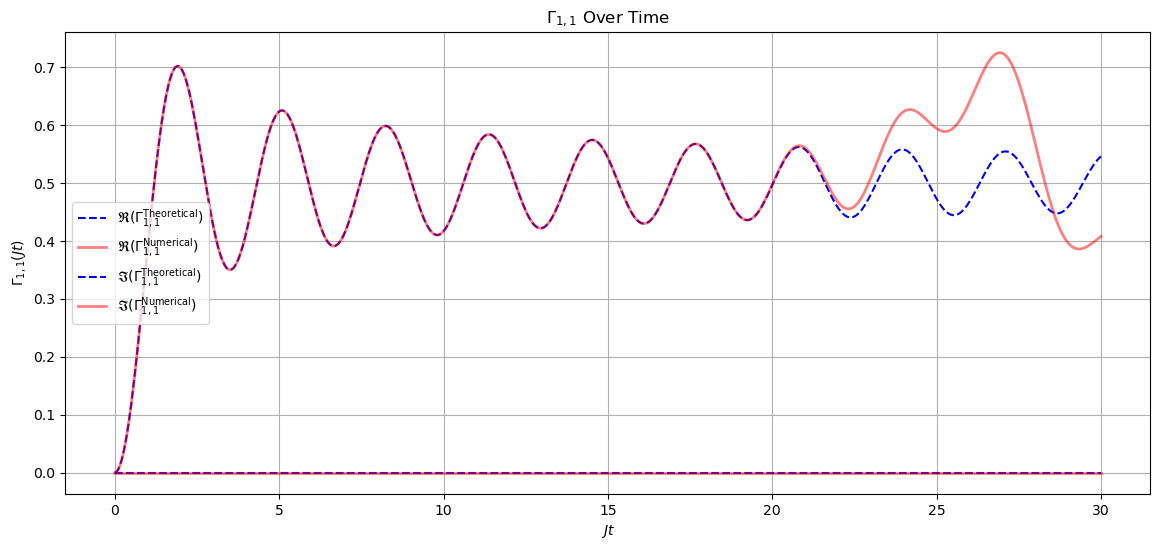

In [21]:
plot_comparison_covariance_matrix_ij(gamma_t_theoretical, gamma_t_numerical, Jt_values, 1,1)

We observe that exist a value $Jt_{critical}$ such that, for $Jt>Jt_{critical}$ the two simulations don't match. This is due to finite size effect. 

---
---

Computation of the evolution in the Hilbert space of dimension $2^N$, the evolution is very expensive but, for small $N$, we shows that agrees with the previous numerical evolution

In [22]:
from scipy.linalg import expm

In [23]:
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)

In [24]:
def apply_operator_at_site(op, site, N):
    """
    Returns the operator 'op' applied at 'site' position in a chain of length N, 
    with identity matrices at all other sites.
    
    Args:
        op: np.ndarray, the operator to apply at the specified site (e.g., sigma_x)
        site: int, the site index where 'op' should be applied (0-indexed)
        N: int, the total number of sites
    
    Returns:
        result(np.ndarray): the full matrix for the chain with 'op' at the given site
    """
    # Start with identity matrices at all sites
    operators = [np.eye(2) for _ in range(N)]
    
    # Replace the identity at the target site with the specified operator
    operators[site] = op
    
    # Construct the full matrix by taking the Kronecker product
    result = operators[0]
    for i in range(1, N):
        result = np.kron(result, operators[i])
    
    return result

In [25]:
def build_hopping_hamiltonian_hilbert(J, N):
    """
    Constructs the hopping Hamiltonian with periodic boundary conditions.
    
    Parameters:
    J(float): Hopping parameter
    N(int): Number of sites
    
    Returns:
        H(np.ndarray): the hopping Hamiltonian matrix
    """
    H = np.zeros((2**N, 2**N), dtype=complex)
    
    for j in range(N):
        # Site j and (j+1) % N for periodic boundary conditions
        site_next = (j + 1) % N
        
        # Create terms sigma_j^+ sigma_(j+1)^- and sigma_j^- sigma_(j+1)^+
        term1 = apply_operator_at_site(sigma_plus, j, N) @ apply_operator_at_site(sigma_minus, site_next, N)
        term2 = apply_operator_at_site(sigma_minus, j, N) @ apply_operator_at_site(sigma_plus, site_next, N)
        
        # Add terms to the Hamiltonian
        H += -J / 2 * (term1 + term2)
    
    return H

def time_evolution(H, t):
    return expm(-1j * H * t)

In [26]:
def neel_state(N):
    """
    Create the Neel state for N spins using the tensor product |ψ(0)⟩ =|01...01⟩.

    Args:
        N (int): Number of spins.

    Returns:
        neel (np.ndarray): Neel state as a vector.
    """
    # Define the single-spin states |0⟩ and |1⟩
    spin_down = np.array([0, 1], dtype=complex)  # |0⟩
    spin_up = np.array([1, 0], dtype=complex)    # |1⟩
    neel = spin_down
    # Start with the first spin, alternating between |0⟩ and |1⟩
    if N % 2 == 0:
        # For even N, start with |0⟩ and alternate |0⟩ |1⟩ |0⟩ |1⟩ ...|0⟩ |1⟩
        for i in range(1, N):
            if i % 2 == 0:
                neel = np.kron(neel, spin_down)
            else:
                neel = np.kron(neel, spin_up)
    else:
        # For odd N start with |0⟩ and alternate |0⟩ |1⟩ |0⟩ |1⟩ ...|1⟩ |0⟩
        for i in range(1, N-1):
            if i % 2 == 0:
                neel = np.kron(neel, spin_down)
            else:
                neel = np.kron(neel, spin_up)
        neel = np.kron(neel, spin_down)
    # Normalize the state vector
    return neel / np.linalg.norm(neel)

In [27]:
def correlator_operator(N):
    """
    Construct the fermionic creation and annihilation operators ⟨c†_i c_j⟩ for N sites.

    Args:
        N (int): Number of sites (spins).

    Returns:
        gamma_operator(np.ndarray): An array of size (N, N, 2^N, 2^N) containing the two-point correlation operators.
    """
    # Initialize gamma_operator as a (N, N, 2^N, 2^N) array
    gamma_operator = np.zeros((N, N, 2**N, 2**N), dtype=complex)

    # Loop over each site pair (i, j)
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            # Construct the annihilation operator (c_j) for site j
            c_j = 1
            for k in range(1, N + 1):
                if k == j:
                    c_j = np.kron(c_j, sigma_minus)
                else:
                    c_j = np.kron(c_j, np.identity(2))

            # Construct the creation operator (c†_i) for site i
            c_dagger_i = 1
            for k in range(1, N + 1):
                if k == i:
                    c_dagger_i = np.kron(c_dagger_i, sigma_plus)
                else:
                    c_dagger_i = np.kron(c_dagger_i, np.identity(2))

            # Calculate the two-point correlation operator ⟨c†_i c_j⟩ and store it
            gamma_operator[i-1, j-1] = c_dagger_i @ c_j

    return gamma_operator


def correlator_average(N,initial_state, correlator_operator):
    """
    Compute the average of the two-point correlation operator ⟨c†_i c_j⟩ for a given initial state.

    Args:
        N (int): Number of sites.
        initial_state (np.ndarray): Initial state vector.
        correlator_operator (np.ndarray): Two-point correlation operator  c†_i c_j
    
    Returns:
        gamma (np.ndarray): Average of the two-point correlation operator ⟨c†_i c_j⟩.
    """
    gamma = np.zeros((N, N), dtype=complex)
    gamma_operator = correlator_operator(N)
    for i in range(N):
        for j in range(N):
            gamma[i, j] = initial_state.conj().T @ gamma_operator[i, j] @ initial_state 
    return gamma

In [28]:
def evolve_gamma_matrix_heisenberg_picture(J, N, t_init, t_final, t_step,initial_state):
    """
    Evolve the two-point correlation matrix γ_ij(t) = ⟨ψ| U†(t) c†_i c_j U(t)|ψ⟩ for a given initial state |ψ(0)⟩ in the Heinseberg picture.

    Args:
        J (float): Hopping parameter.
        N (int): Number of sites.
        t_init (float): Initial time.
        t_final (float): Final time.
        t_step (float): Time step.
        initial_state (np.ndarray): Initial state vector.
    
    Returns:
        gamma_t_series (np.ndarray): Array of γ_ij(t) for each time step.
    """
    # Construct the Hamiltonian
    H = build_hopping_hamiltonian_hilbert(J, N)
    
    # Time evolution steps
    t_values = np.arange(t_init, t_final + t_step, t_step)
    gamma_t_series = []

    # Initialize the gamma matrix with fermionic operators
    gamma_operator= correlator_operator(N)
    # Evolve each operator in the Heisenberg picture
    for t in tqdm(t_values):
        # Compute the time evolution operator U(t)
        U_t = time_evolution(H, t)
        U_t_dagger = U_t.conj().T  # U†(t)
        
        # Evolve each two-point operator: γ_ij(t) = U†(t) γ_ij(0) U(t)
        gamma_evolved = np.zeros((N, N, 2**N, 2**N), dtype=complex)
        for i in range(N):
            for j in range(N):
                gamma_evolved[i, j] = U_t_dagger @ gamma_operator[i, j] @ U_t
        
        gamma_t = np.zeros((N, N), dtype=complex)
        for r in range(N):
            for s in range(N):
                # Expectation value: ⟨ψ(0)| γ_ij(t) |ψ(0)⟩
                gamma_t[r, s] = initial_state.conj().T @ gamma_evolved[r, s] @ initial_state
        
        gamma_t_series.append(gamma_t)
    
    return np.array(gamma_t_series), t_values


In [ ]:
N=6
J=1
h=0
t_init = 0
t_final = 120
t_step = 0.1
H = build_hopping_hamiltonian(J,N)

In [205]:
xx_ising_chain_no_magnetic_field_small_N = QuantumIsingChain1D(N=N, J=J, h=h, H=H)
initial_gamma = gamma_0(N)
gamma_t_numerical , Jt_values = xx_ising_chain_no_magnetic_field_small_N.compute_time_evolution_covariance_matrix(t_init,t_final,t_step,initial_gamma)

Computing Numerical Evolution: 100%|██████████| 601/601 [00:03<00:00, 178.51it/s]


In [206]:
gamma_t_heisenberg, t_values = evolve_gamma_matrix_heisenberg_picture(J, N, t_init, t_final, t_step,neel_state(N))    

100%|██████████| 601/601 [00:03<00:00, 165.38it/s]


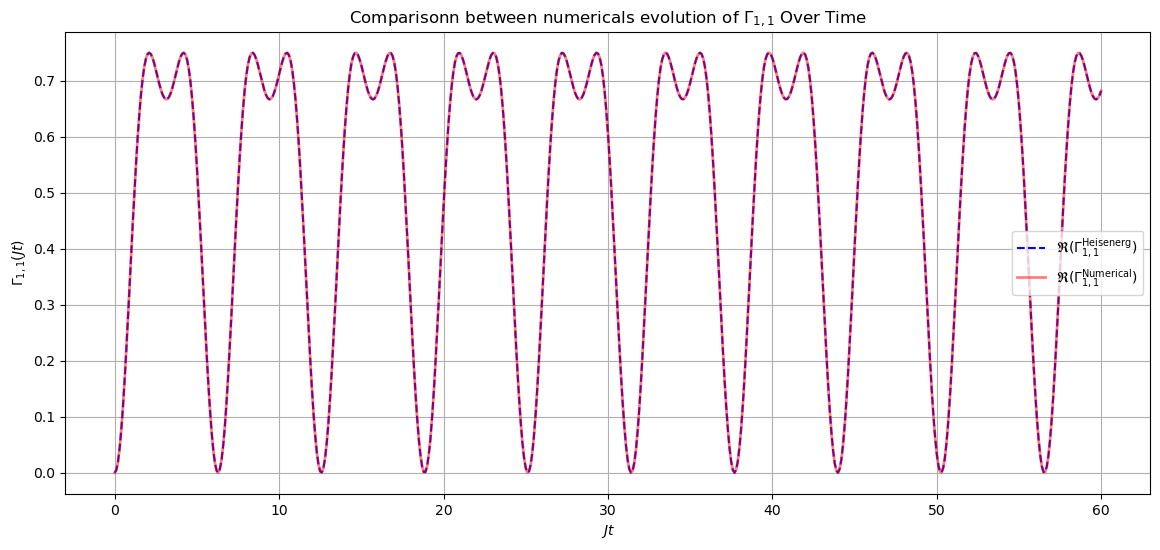

In [207]:
gamma_real_numerical = [gamma_t[2,2].real for gamma_t in gamma_t_numerical]
gamma_real_heisenberg = [gamma_t[2,2].real for gamma_t in gamma_t_heisenberg]
plt.figure(figsize=(14, 6))

plt.plot(t_values,gamma_real_heisenberg, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Heisenerg}}_{%d,%d})$" % (1,1), color="blue",linestyle="--")
plt.plot(t_values,gamma_real_numerical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" % (  1,1),linewidth=2,alpha=0.5, color="red")
plt.title(r"Comparisonn between numericals evolution of $\Gamma_{%d,%d}$ Over Time" % (1,1))
plt.xlabel("$Jt$")
plt.ylabel(r"$\Gamma_{%d,%d}(Jt)$" % (1,1))
plt.legend()
plt.grid(True)

---
---

Computation of the dependence of $Jt_{critical}$ with the system size $N$.

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
def compute_divergence_time(N_intial,N_final,N_step, t_init, t_final, t_step, J, threshold,row,col):
    """
    Compute the special value of Jt where theoretical and numerical results diverge.
    Parameters:
        N_values : list of matrix sizes
        t_init, t_final : time range
        t_step : step size for time
        J : hopping parameter
        threshold : divergence threshold for relative error
    Returns:
        critical_times : list of critical Jt values for each N
    """
    critical_times = []

    N_values = np.arange(N_intial, N_final, N_step)

    for N in tqdm(N_values, desc="Processing N values"):
        # Compute theoretical Gamma
        gamma_theoretical, t_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=True)
        
        # Compute numerical Gamma
        initial_state = gamma_0(N)
        xx_ising_chain_no_magnetic_field = QuantumIsingChain1D(N=N, J=J, h=0, H=build_hopping_hamiltonian(J,N))
        gamma_numerical, _ = xx_ising_chain_no_magnetic_field.compute_time_evolution_covariance_matrix(t_init, t_final, t_step, initial_state ,disable_tqdm=True)
        
        # Compute the divergence time
        for t_idx, (gamma_th, gamma_num) in enumerate(zip(gamma_theoretical, gamma_numerical)):
            rel_diff = np.abs((gamma_th[row,col] - gamma_num[row,col]) )
            if rel_diff > threshold:
                critical_times.append(t_values[t_idx])
                break
        else:
            critical_times.append(np.nan)  # No divergence found within the range

    return critical_times , N_values

In [47]:
threshold = 0.01
N_initial = 50
N_final=100
N_step=10
t_init = 0
t_final = 30
t_step = 0.1
J=10

# Compute the critical times
critical_t, N_values = compute_divergence_time(N_initial,N_final,N_step, t_init, t_final, t_step, J, threshold,2,2)

Processing N values: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


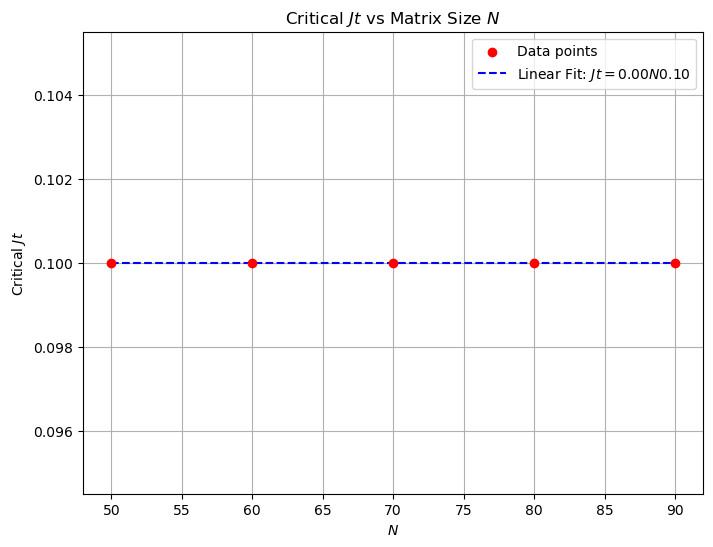

Linear Fit Parameters: Slope (a) = 0.000, Intercept (b) = 0.100


In [48]:
N_values_reshaped = N_values.reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(N_values_reshaped, critical_t)
a = model.coef_[0]  # Slope
b = model.intercept_  # Intercept

# Generate a smooth line for the linear fit
N_fit = np.linspace(min(N_values), max(N_values), 500)
Jt_fit = a * N_fit + b

# Plot the data points and the linear fit
plt.figure(figsize=(8, 6))
plt.scatter(N_values, critical_t, color='red', label='Data points', zorder=5)
plt.plot(N_fit, Jt_fit, color='blue', linestyle='--', label=f'Linear Fit: $Jt = {a:.2f}N {b:.2f}$')
plt.title("Critical $Jt$ vs Matrix Size $N$")
plt.xlabel("$N$")
plt.ylabel("Critical $Jt$")
plt.legend()
plt.grid(True)
plt.show()

print(f"Linear Fit Parameters: Slope (a) = {a:.3f}, Intercept (b) = {b:.3f}")

In [49]:
from matplotlib.colors import LinearSegmentedColormap

def plot_light_cone_effect(N, J, t_max, t_steps, k=0):
    """
    Plot the light-cone effect for the connected density-density correlator with custom colors.

    Parameters:
        N (int): Number of lattice sites.
        J (float): Coupling constant.
        t_max (float): Maximum time (in units of Jt).
        t_steps (int): Number of time steps.
        k (int): Reference site index (default is 0).
    """
    # Define position and time values
    j_values = np.arange(-N // 2, N // 2 + 1)  # Positions centered around k
    t_values = np.linspace(0, t_max, t_steps)  # Time points

    # Initialize the connected correlator array
    correlator = np.zeros((len(t_values), len(j_values)))  # Swap dimensions

    # Compute the correlator for each time and position
    for j_idx, j in enumerate(j_values):
        for t_idx, t in enumerate(t_values):
            delta_jk = abs(j - k)
            if delta_jk == 0:
                correlator[t_idx, j_idx] = 1 / 4  # Diagonal term
            else:
                correlator[t_idx, j_idx] = -1 / 4 * jv(delta_jk, 4 * J * t)**2

    # Define a custom colormap similar to the reference image
    colors = [(0.6, 0.4, 0.2), (1.0, 1.0, 0.0), (1.0, 1.0, 1.0)]  # Brown -> Yellow -> White
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Plot the light-cone effect with swapped axes
    plt.figure(figsize=(10, 6))
    plt.imshow(
        correlator, extent=[j_values[0], j_values[-1], 0, t_max],
        aspect='auto', origin='lower', cmap=cmap, vmin=-0.1, vmax=0.25
    )
    plt.colorbar(label=r'$\langle n_j(t) n_k(t) \rangle_c$')
    plt.ylabel(r'$Jt$')  # Swapped axis
    plt.xlabel(r'$j$')  # Swapped axis
    plt.title('Light-Cone Effect for Connected Density-Density Correlator (Custom Colors)')
    plt.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.7)  # Highlight time origin
    plt.grid(False)
    plt.show()

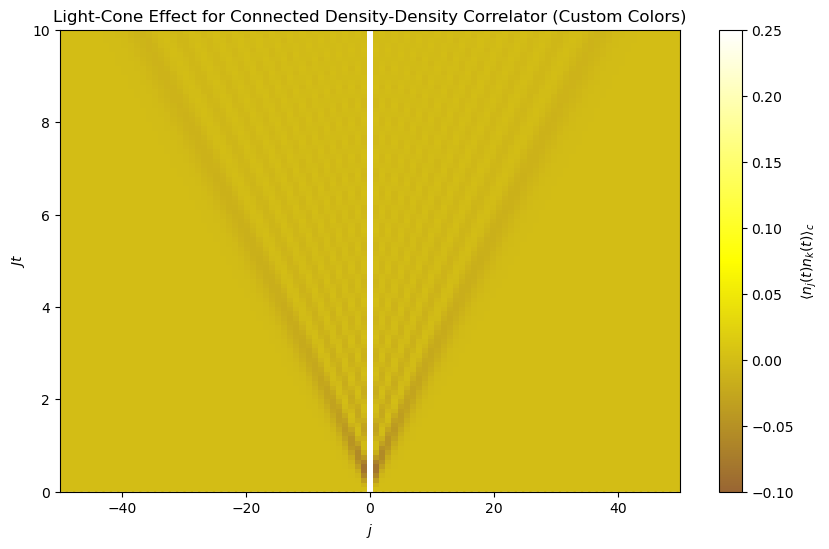

In [50]:
plot_light_cone_effect(N=100, J=1, t_max=10, t_steps=100, k=0)

---
---

Trotterize evolution of the correlation matrix

In [171]:
def compute_local_evolution_operator(N, j, J, tau):
    """
    Compute the local evolution operator U_{j,j+1} for Trotterized evolution with periodic boundary conditions.

    Args:
        N (int): Total number of sites.
        j (int): Index of the first site in the pair (j, j+1).
        J (float): Coupling constant.
        tau (float): Trotter step size.

    Returns:
        U (numpy.ndarray): The N x N matrix with the local evolution applied to sites (j, j+1).
    """
    theta = J * tau / 2  # Angle for the sinusoidal functions

    # Construct the 2x2 matrix using cos and sin
    u_local = np.array([
        [np.cos(theta), 1j * np.sin(theta)],
        [1j * np.sin(theta), np.cos(theta)]
    ], dtype=complex)

    # Embed u_local into the full N x N matrix
    U = np.eye(N, dtype=complex)
    U[j, j] = u_local[0, 0]
    U[j, (j + 1) % N] = u_local[0, 1]  # Use modulo to wrap around for periodic boundary
    U[(j + 1) % N, j] = u_local[1, 0]
    U[(j + 1) % N, (j + 1) % N] = u_local[1, 1]

    return U

In [172]:
def compute_even_operator(N, J, tau):
    """
    Compute the evolution operator for the even part of the Hamiltonian.

    Args:
        N (int): Total number of sites.
        J (float): Coupling constant.
        tau (float): Trotter step size.

    Returns:
        U_even (numpy.ndarray): The N x N evolution operator for the even part.
    """
    U_even = np.eye(N, dtype=complex)  # Initialize as identity matrix

    # Loop over even pairs (e.g., (0, 1), (2, 3), etc.)
    for j in range(0, N - 1, 2):
        U_local = compute_local_evolution_operator(N, j, J, tau)
        U_even = U_local @ U_even  # Multiply local operator into global one

    return U_even


def compute_odd_operator(N, J, tau):
    """
    Compute the evolution operator for the odd part of the Hamiltonian,
    considering periodic boundary conditions.

    Args:
        N (int): Total number of sites.
        J (float): Coupling constant.
        tau (float): Trotter step size.
    
    Returns:
        U_odd (numpy.ndarray): The N x N evolution operator for the odd part.
    """
    U_odd = np.eye(N, dtype=complex)  # Initialize as identity matrix

    # Loop over odd pairs (e.g., (1, 2), (3, 4), etc.)
    for j in range(1, N - 1, 2):
        U_local = compute_local_evolution_operator(N, j, J, tau)
        U_odd = U_local @ U_odd  # Multiply local operator into global one

    # Include the pair (N-1, 0) for periodic boundary conditions
    U_local_pbc = compute_local_evolution_operator(N, N - 1, J, tau)
    U_odd = U_local_pbc @ U_odd

    return U_odd

In [173]:
def compute_trotter_evolution_operator(N, J, t, tau):
    """
    Compute the Trotterized time evolution operator for time `t` using Trotter decomposition.

    Args:
        N (int): Total number of sites.
        J (float): Coupling constant.
        t (float): Total evolution time.
        tau (float): Trotter step size.

    Returns:
        U_trotter (numpy.ndarray): The N x N matrix representing the Trotterized time evolution operator.
    """
    # Number of Trotter steps
    n_steps = int(t / tau)

    # Compute even and odd evolution operators for one Trotter step
    U_even = compute_even_operator(N, J, tau)
    U_odd = compute_odd_operator(N, J, tau)

    # Initialize the total evolution operator as identity
    U_trotter = np.eye(N, dtype=complex)

    # Apply the Trotter step `n_steps` times
    for _ in range(n_steps):
        U_trotter = U_even @ U_odd @ U_trotter

    return U_trotter

In [174]:
def evolve_correlation_matrix_trotter(N, J, t_init, t_final, t_step, tau, gamma_0):
    """
    Compute the time evolution of the correlation matrix using Trotterized evolution.

    Args:
        N (int): Total number of sites.
        J (float): Coupling constant.
        t_init (float): Initial time.
        t_final (float): Final time.
        t_step (float): Time step for saving results.
        tau (float): Trotter step size.
        gamma_0 (numpy.ndarray): Initial correlation matrix.

    Returns:
        gamma_t_series (numpy.ndarray): Array of correlation matrices at each saved time step.
        t_values (numpy.ndarray): Array of time points corresponding to saved matrices.
    """
    # Initialize time values
    t_values = np.arange(t_init, t_final + t_step, t_step)

    # Array to store correlation matrices at each time step
    gamma_t_series = []

    # Iterate through time steps
    for t in tqdm(t_values, desc = "Computing Trotterized Evolution"):
        # Compute the Trotterized evolution operator for one t_step
        U_trotter = compute_trotter_evolution_operator(N, J, t, tau)

        # Update the correlation matrix: Γ(t) = U Γ(0) U†
        gamma_t = U_trotter.conj().T @ gamma_0 @ U_trotter

        # Store the updated correlation matrix
        gamma_t_series.append(gamma_t)

    return np.array(gamma_t_series), t_values

In [199]:
N=40
J=1
h=0
t_init = 0
t_final = 30
t_step = 0.1
tau=0.01
H = build_hopping_hamiltonian(J,N)
initial_gamma = gamma_0(N)

In [200]:
gamma_t_trotter, t_values = evolve_correlation_matrix_trotter(N, J, t_init, t_final, t_step, tau, initial_gamma)

Computing Trotterized Evolution: 100%|██████████| 301/301 [00:16<00:00, 18.61it/s]


In [201]:
xx_ising_chain_no_magnetic_field_comparison = QuantumIsingChain1D(N=N, J=J, h=h, H=H)
gamma_t_numerical , Jt_values = xx_ising_chain_no_magnetic_field_comparison.compute_time_evolution_covariance_matrix(t_init,t_final,t_step,initial_gamma)

Computing Numerical Evolution: 100%|██████████| 301/301 [00:00<00:00, 2187.57it/s]


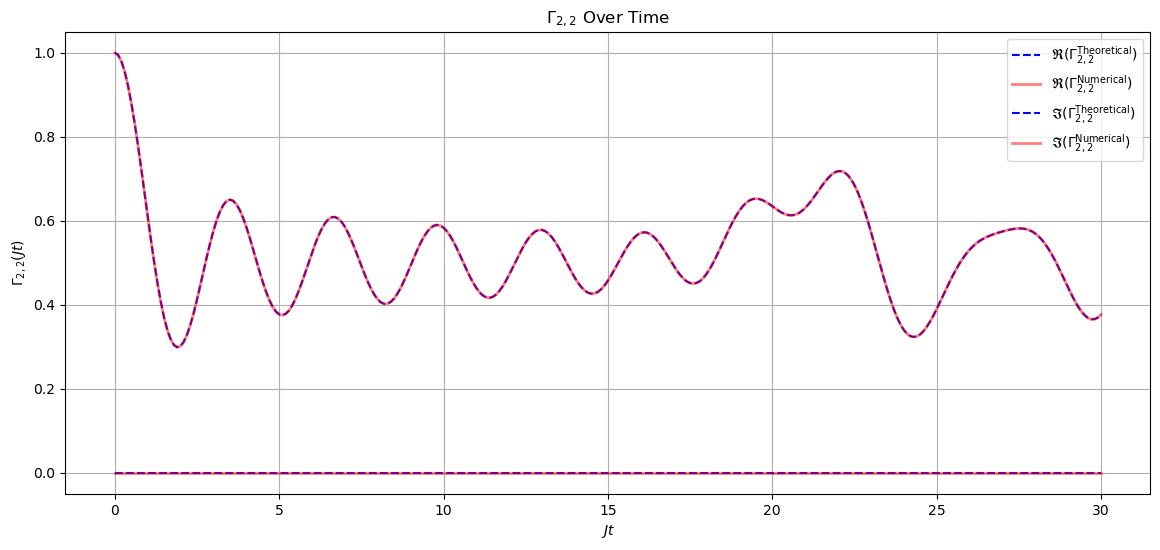

In [203]:
plot_comparison_covariance_matrix_ij(gamma_t_trotter, gamma_t_numerical, Jt_values, 2,2)